<a href="https://colab.research.google.com/github/abdelrhmanhesham1/projects/blob/main/housing%20prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing Values:
 price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
Rows after duplicates removal: 545
Rows after outlier removal: 365

Summary Statistics:
               price          area    bedrooms  bathrooms     stories  \
count  3.650000e+02    365.000000  365.000000      365.0  365.000000   
mean   4.045012e+06   4623.810959    2.742466        1.0    1.553425   
std    1.247181e+06   1723.729307    0.624130        0.0    0.616192   
min    1.750000e+06   1650.000000    1.000000        1.0    1.000000   
25%    3.150000e+06   3460.000000    2.000000        1.0    1.000000   
50%    3.850000e+06   4079.000000    3.000000        1.0    1.000000   
75%    4.690000e+06   5800.000000    3.000000        1.0    2.000000   
max    9.100000e+06

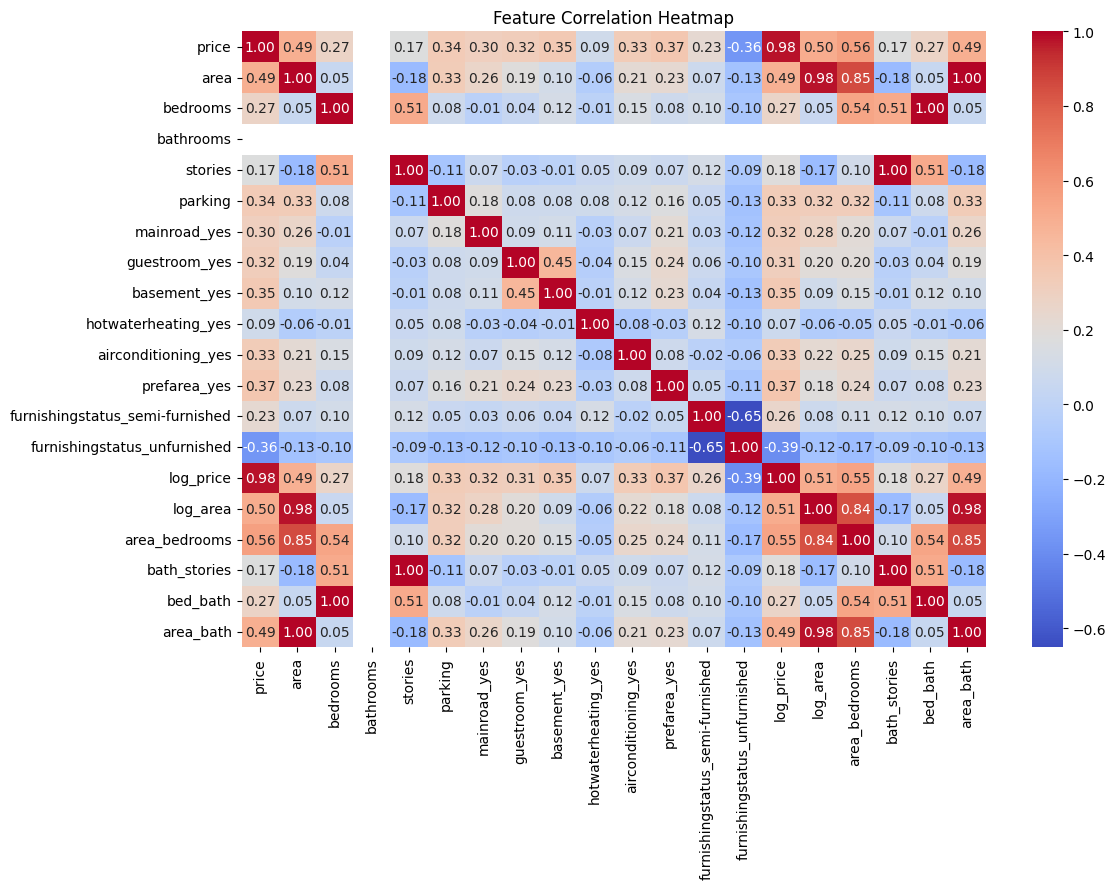

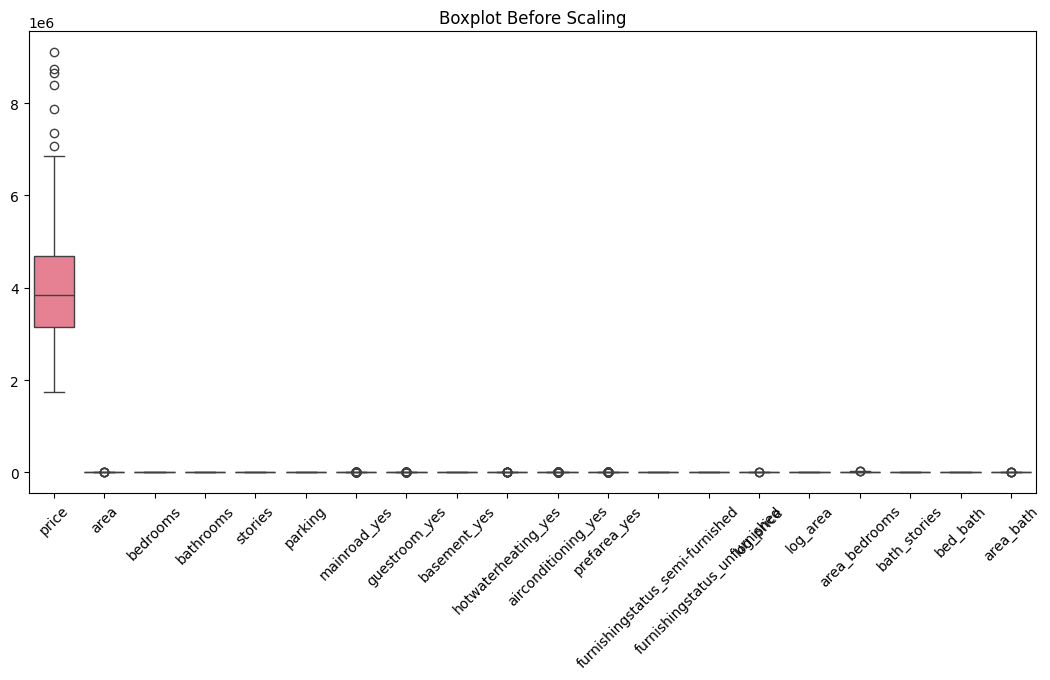

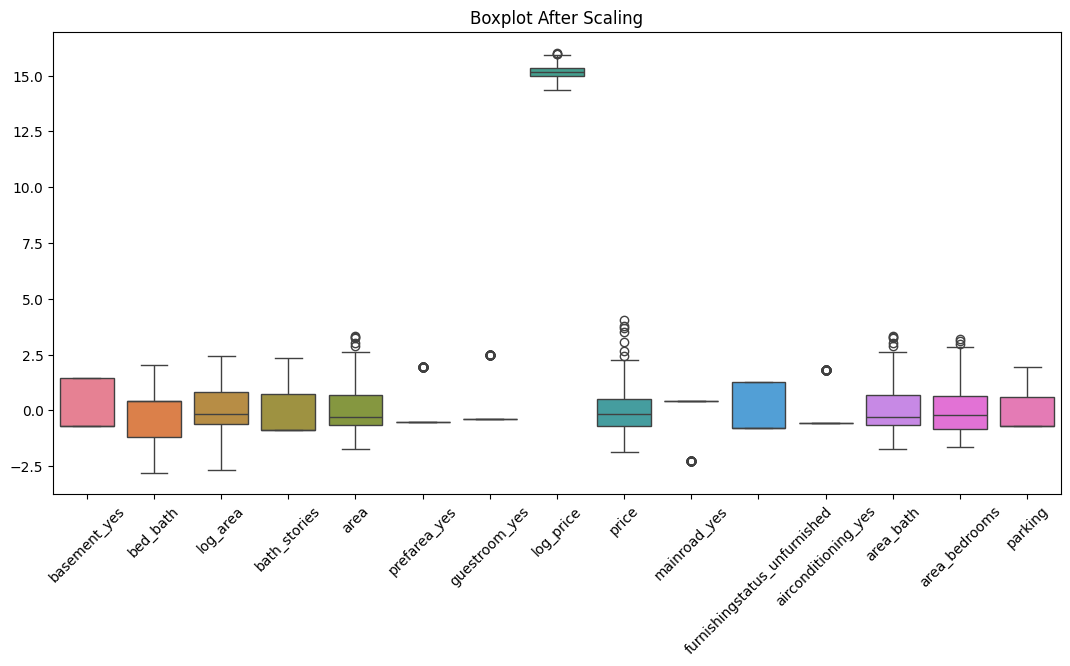


Custom Linear Regression Results:
MAE: 222568.82
R²: 0.9559

Scikit-Learn Linear Regression Results:
MAE: 222568.82
R²: 0.9559

Polynomial Regression (Degree 3, Ridge) Results:
MAE: 139193.19
R²: 0.9757


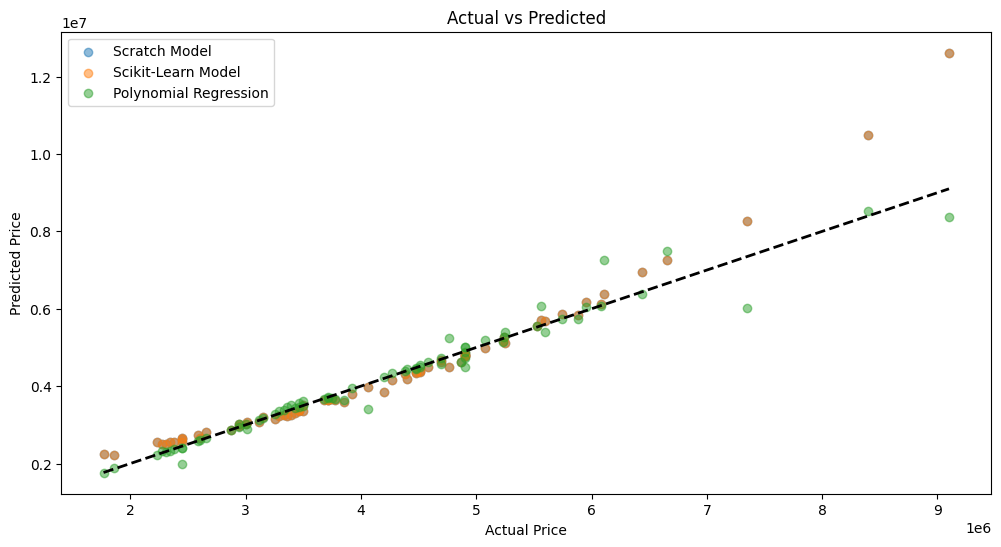

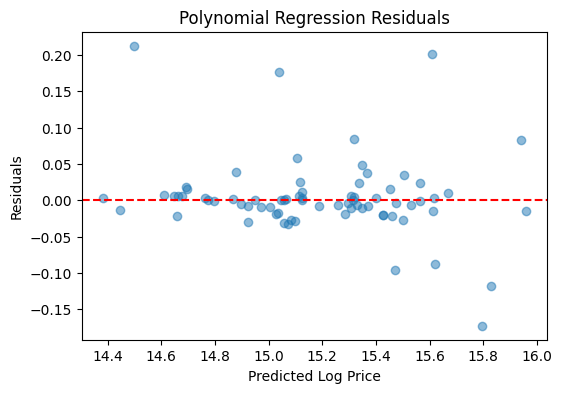

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as SkLinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('/content/Housing.csv')
df.describe()

print("Missing Values:\n", df.isnull().sum())
df = df.drop_duplicates()
print(f"Rows after duplicates removal: {len(df)}")


# One-hot encoding
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Feature Engineering
df['log_price'] = np.log1p(df['price'])
df['log_area'] = np.log1p(df['area'])
df['area_bedrooms'] = df['area'] * df['bedrooms']
df['bath_stories'] = df['bathrooms'] * df['stories']
df['bed_bath'] = df['bedrooms'] * df['bathrooms']
df['area_bath'] = df['area'] * df['bathrooms']

# IQR Outlier Removal
def remove_outliers(df, column, factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']:
    df = remove_outliers(df, col)
print(f"Rows after outlier removal: {len(df)}")

# Summary statistics
print("\nSummary Statistics:\n", df.describe())

# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Boxplot before scaling
plt.figure(figsize=(13, 6))
sns.boxplot(data=df)
plt.title('Boxplot Before Scaling')
plt.xticks(rotation=45)
plt.show()

# Feature selection
selected_features = df.corr()['price'][abs(df.corr()['price']) > 0.3].index.tolist()
selected_features = list(set(selected_features + ['log_price', 'log_area', 'area_bedrooms', 'bath_stories', 'bed_bath', 'area_bath']))
df_selected = df[selected_features]

# Standardize features
scaler = StandardScaler()
numerical_features = df_selected.columns.drop('log_price')
df_selected[numerical_features] = scaler.fit_transform(df_selected[numerical_features])

# Boxplot after scaling
plt.figure(figsize=(13, 6))
sns.boxplot(data=df_selected)
plt.title('Boxplot After Scaling')
plt.xticks(rotation=45)
plt.show()

# Train-test split
X = df_selected.drop('log_price', axis=1)
y = df_selected['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#LinearRegression
class LinearRegression:
    def __init__(self):
        self.coefficients = None
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.coefficients = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.coefficients)
    def evaluate(self, y_true, y_pred, name="Custom Linear Regression"):
        y_true_orig = np.expm1(y_true)
        y_pred_orig = np.expm1(y_pred)
        mae = mean_absolute_error(y_true_orig, y_pred_orig)
        r2 = r2_score(y_true, y_pred)
        print(f"\n{name} Results:")
        print(f"MAE: {mae:.2f}")
        print(f"R²: {r2:.4f}")
        return  mae, r2

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
lr_mae, lr_r2 = lr.evaluate(y_test, y_pred)

# --- Scikit-Learn Linear Regression ---
sk_lr = SkLinearRegression()
sk_lr.fit(X_train, y_train)
y_pred_sk = sk_lr.predict(X_test)
sk_mae, sk_r2 = lr.evaluate(y_test, y_pred_sk, "Scikit-Learn Linear Regression")

#Polynomial Regression
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)
poly_lr = Ridge(alpha=1.0)
poly_lr.fit(X_train_poly, y_train)
y_pred_poly = poly_lr.predict(X_test_poly)
poly_mae, poly_r2 = lr.evaluate(y_test, y_pred_poly, "Polynomial Regression (Degree 3, Ridge)")

#Visualization
df_results = pd.DataFrame({
    'Actual': np.expm1(y_test), 'Custom Linear': np.expm1(y_pred),'Scikit-Learn Linear': np.expm1(y_pred_sk),
    'Polynomial': np.expm1(y_pred_poly)
}).melt(id_vars=['Actual'], var_name='Model', value_name='Predicted')

fig = px.scatter(df_results, x='Actual', y='Predicted', color='Model', title="Actual vs Predicted Prices",
                 labels={'Actual': 'Actual Price', 'Predicted': 'Predicted Price'})
fig.add_trace(go.Scatter(
    x=[df_results['Actual'].min(), df_results['Actual'].max()],
    y=[df_results['Actual'].min(), df_results['Actual'].max()],
    mode='lines', name='Ideal Prediction', line=dict(dash='dash', color='black')
))
fig.show()

plt.figure(figsize=(12, 6))
plt.scatter(np.expm1(y_test), np.expm1(y_pred), label='Scratch Model', alpha=0.5)
plt.scatter(np.expm1(y_test), np.expm1(y_pred_sk), label='Scikit-Learn Model', alpha=0.5)
plt.scatter(np.expm1(y_test), np.expm1(y_pred_poly), label='Polynomial Regression', alpha=0.5)
plt.plot([np.expm1(y_test).min(), np.expm1(y_test).max()], [np.expm1(y_test).min(), np.expm1(y_test).max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.scatter(y_pred_poly, y_test - y_pred_poly, alpha=0.5)
plt.xlabel("Predicted Log Price")
plt.ylabel("Residuals")
plt.title("Polynomial Regression Residuals")
plt.axhline(0, color='r', linestyle='--')
plt.show()